### LLAMA

In [2]:
import numpy as np
import pandas as pd
from datasets import load_dataset, Dataset
from transformers import AutoTokenizer, BitsAndBytesConfig, pipeline
from transformers.pipelines.pt_utils import KeyDataset
from peft import PeftModel, PeftConfig
from dotenv import dotenv_values
import torch
from tqdm.auto import tqdm
import evaluate

from utils import DataPreprocessor, DatasetFormatConverter, Evaluator, OutputGenerator
from utils import DataPreprocessor

from src.billm import LlamaForTokenClassification

WANDB_KEY = dotenv_values(".env.base")['WANDB_KEY']
LLAMA_TOKEN = dotenv_values(".env.base")['LLAMA_TOKEN']
HF_TOKEN = dotenv_values(".env.base")['HF_TOKEN']
HF_TOKEN_WRITE = dotenv_values(".env.base")['HF_TOKEN_WRITE']


adapters = "ferrazzipietro/LS_Llama-2-7b-hf_adapters_en.layer1_NoQuant_64_64_0.01_2_0.0002"
peft_config = PeftConfig.from_pretrained(adapters)
BASE_MODEL_CHECKPOINT = peft_config.base_model_name_or_path

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_CHECKPOINT,token =HF_TOKEN)
tokenizer.pad_token = tokenizer.eos_token
# seqeval = evaluate.load("seqeval")
DATASET_CHEKPOINT="ferrazzipietro/e3c-sentences" 
TRAIN_LAYER="en.layer1"
preprocessor = DataPreprocessor(BASE_MODEL_CHECKPOINT, 
                                tokenizer)
dataset = load_dataset(DATASET_CHEKPOINT) #download_mode="force_redownload"
dataset = dataset[TRAIN_LAYER]
dataset = dataset.shuffle(seed=1234)  
dataset_format_converter = DatasetFormatConverter(dataset)
dataset_format_converter.apply()
ds = dataset_format_converter.dataset
label2id = dataset_format_converter.label2id
id2label = dataset_format_converter.get_id2label()
label_list = dataset_format_converter.get_label_list()
dataset_format_converter.set_tokenizer(tokenizer)
dataset_format_converter.set_max_seq_length(256)
tokenized_ds = ds.map(lambda x: dataset_format_converter.tokenize_and_align_labels(x), batched=True)# dataset_format_converter.dataset.map(tokenize_and_align_labels, batched=True)
_, val_data, _ = preprocessor.split_layer_into_train_val_test_(tokenized_ds, TRAIN_LAYER)


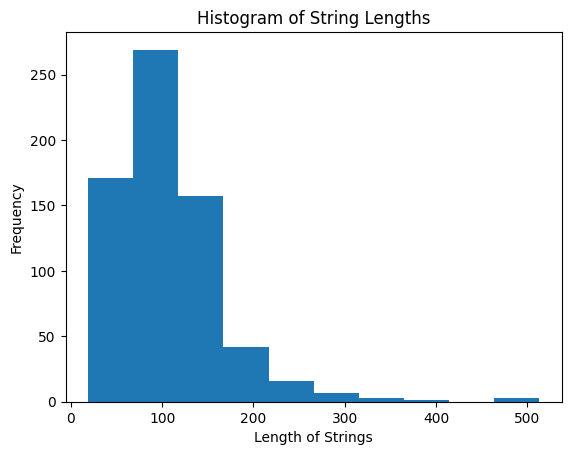

In [ ]:
import matplotlib.pyplot as plt

# Get the lengths of the strings
lengths = [len(sentence) for sentence in train_data['sentence']]

# Plot the histogram
plt.hist(lengths, bins=10)
plt.xlabel('Length of Strings')
plt.ylabel('Frequency')
plt.title('Histogram of String Lengths')
plt.show()

In [3]:
bnb_config = BitsAndBytesConfig(
                load_in_4bit=True,
                bnb_4bit_use_double_quant=True,
                bnb_4bit_quant_type="nf4",
                bnb_4bit_compute_dtype=torch.bfloat16,
                )

model = LlamaForTokenClassification.from_pretrained(
    peft_config.base_model_name_or_path,
    num_labels=len(label2id), id2label=id2label, label2id=label2id,
    token = HF_TOKEN,
    cache_dir='/data/disk1/share/pferrazzi/.cache',
    device_map='auto',
    quantization_config = bnb_config)
model = PeftModel.from_pretrained(model, adapters, token = HF_TOKEN)
model = model.merge_and_unload()

Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.22s/it]
Some weights of LlamaForTokenClassification were not initialized from the model checkpoint at meta-llama/Llama-2-7b-hf and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You are calling `save_pretrained` to a 4-bit converted model, but your `bitsandbytes` version doesn't support it. If you want to save 4-bit models, make sure to have `bitsandbytes>=0.41.3` installed.
/home/pferrazzi/LS-LLaMA-E3C/.venv/lib/python3.11/site-packages/peft/tuners/lora/bnb.py:325: UserWarning: Merge lora module to 4-bit linear may get different generations due to rounding errors.
  warnings.warn(


In [ ]:
generator = OutputGenerator(model, tokenizer, label2id, label_list)
test_data = generator.generate(val_data, batch_size = 84)

In [6]:
test_data.push_to_hub('ferrazzipietro/LS_Llama-2-7b-hf_adapters_en.layer1_NoQuant_64_64_0.01_2_0.0002', token=HF_TOKEN_WRITE)

Uploading the dataset shards: 100%|██████████| 1/1 [00:01<00:00,  1.91s/it]


CommitInfo(commit_url='https://huggingface.co/datasets/ferrazzipietro/LS_Llama-2-7b-hf_adapters_en.layer1_NoQuant_64_64_0.01_2_0.0002/commit/7c872b6f527dc27c005f1101cc1d3ce0d7286f3e', commit_message='Upload dataset', commit_description='', oid='7c872b6f527dc27c005f1101cc1d3ce0d7286f3e', pr_url=None, pr_revision=None, pr_num=None)

In [8]:
test_data = load_dataset('ferrazzipietro/LS_Llama-2-7b-hf_adapters_en.layer1_NoQuant_64_64_0.01_2_0.0002', token=HF_TOKEN, split='train')
print(test_data)
eval = Evaluator(test_data, tokenizer)
eval.extract_FP_FN_TP()
eval.create_evaluation_table()
print(eval.evaluation_table)
eval.print_disallined_Is()

Generating train split: 100%|██████████| 681/681 [00:00<00:00, 57944.60 examples/s]


Dataset({
    features: ['sentence', 'entities', 'original_text', 'original_id', 'tokens', 'ner_tags', 'input_ids', 'attention_mask', 'labels', 'predictions', 'ground_truth_labels'],
    num_rows: 681
})


Map: 100%|██████████| 681/681 [00:00<00:00, 5659.34 examples/s]


{'TP': 8691, 'FP': 3274, 'FN': 1543, 'precision': 0.7263685750104472, 'recall': 0.8492280633183505, 'f1': 0.7830082436145771}
[('<s>', 'B', 'O'), ('▁The', 'B', 'O'), ('▁results', 'O', 'O'), ('▁of', 'O', 'O'), ('▁the', 'B', 'B'), ('▁PC', 'I', 'I'), ('R', 'O', 'O'), ('▁were', 'B', 'B'), ('▁positive', 'O', 'O'), ('▁for', 'B', 'O'), ('▁R', 'I', 'O'), ('NA', 'O', 'O'), ('▁specific', 'O', 'O'), ('▁to', 'B', 'B'), ('▁S', 'I', 'I'), ('AR', 'I', 'I'), ('S', 'I', 'I'), ('-', 'O', 'I'), ('Co', 'I', 'I'), ('V', 'I', 'I'), ('-', 'I', 'I'), ('2', 'I', 'I')]
[('<s>', 'O', 'O'), ('▁Flow', 'B', 'B'), ('▁c', 'O', 'I'), ('yt', 'I', 'I'), ('ometry', 'O', 'O'), ('▁of', 'O', 'B'), ('▁the', 'O', 'I'), ('▁C', 'I', 'I'), ('SF', 'B', 'B'), ('▁showed', 'O', 'O'), ('▁that', 'B', 'B'), ('▁bl', 'I', 'I'), ('ast', 'I', 'I'), ('▁cells', 'O', 'O'), ('▁were', 'O', 'B'), ('▁positive', 'O', 'O'), ('▁for', 'O', 'O'), ('▁a', 'O', 'O'), ('▁cluster', 'O', 'O'), ('▁of', 'O', 'O'), ('▁different', 'O', 'O'), ('iation', 'O', 'B'

## MISTRAL

In [1]:
import numpy as np
import pandas as pd
from datasets import load_dataset, Dataset
from transformers import AutoTokenizer, BitsAndBytesConfig, pipeline
from transformers.pipelines.pt_utils import KeyDataset
from peft import PeftModel, PeftConfig
from dotenv import dotenv_values
import torch
from tqdm.auto import tqdm
import evaluate

from utils import DataPreprocessor, Evaluator, OutputGenerator
from utils import dataset_format_converter
import importlib
importlib.reload(dataset_format_converter)

from utils import DataPreprocessor

from src.billm import MistralForTokenClassification

WANDB_KEY = dotenv_values(".env.base")['WANDB_KEY']
LLAMA_TOKEN = dotenv_values(".env.base")['LLAMA_TOKEN']
HF_TOKEN = dotenv_values(".env.base")['HF_TOKEN']
HF_TOKEN_WRITE = dotenv_values(".env.base")['HF_TOKEN_WRITE']

adapters = "ferrazzipietro/LS_Mistral-7B-v0.1_adapters_en.layer1_NoQuant_64_32_0.01_4_0.0002"
peft_config = PeftConfig.from_pretrained(adapters, token = HF_TOKEN)
BASE_MODEL_CHECKPOINT = peft_config.base_model_name_or_path

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_CHECKPOINT,token =HF_TOKEN)
tokenizer.pad_token = tokenizer.eos_token
# seqeval = evaluate.load("seqeval")
DATASET_CHEKPOINT="ferrazzipietro/e3c-sentences" 
TRAIN_LAYER="en.layer1"
preprocessor = DataPreprocessor(BASE_MODEL_CHECKPOINT, 
                                tokenizer)
dataset = load_dataset(DATASET_CHEKPOINT) #download_mode="force_redownload"
dataset = dataset[TRAIN_LAYER]
dataset = dataset.shuffle(seed=1234)  
dataset_format_converter_obj = dataset_format_converter.DatasetFormatConverter(dataset)
dataset_format_converter_obj.apply()
ds = dataset_format_converter_obj.dataset
label2id = dataset_format_converter_obj.label2id
id2label = dataset_format_converter_obj.get_id2label()
label_list = dataset_format_converter_obj.get_label_list()
dataset_format_converter_obj.set_tokenizer(tokenizer)
dataset_format_converter_obj.set_max_seq_length(256)
tokenized_ds = ds.map(lambda x: dataset_format_converter_obj.tokenize_and_align_labels(x), batched=True)# dataset_format_converter.dataset.map(tokenize_and_align_labels, batched=True)
_, val_data, _ = preprocessor.split_layer_into_train_val_test_(tokenized_ds, TRAIN_LAYER)

bnb_config = BitsAndBytesConfig(
                load_in_4bit=True,
                bnb_4bit_use_double_quant=True,
                bnb_4bit_quant_type="nf4",
                bnb_4bit_compute_dtype=torch.bfloat16,
                )

model = MistralForTokenClassification.from_pretrained(
    peft_config.base_model_name_or_path,
    num_labels=len(label2id), id2label=id2label, label2id=label2id,
    token = HF_TOKEN,
    cache_dir='/data/disk1/share/pferrazzi/.cache',
    device_map='auto',
    quantization_config = bnb_config)
model = PeftModel.from_pretrained(model, adapters, token = HF_TOKEN)
model = model.merge_and_unload()


ImportError: module DatasetFormatConverter not in sys.modules

In [3]:
generator = OutputGenerator(model, tokenizer, label2id, label_list)
test_data = generator.generate(val_data, batch_size = 84)
test_data.push_to_hub(adapters, token=HF_TOKEN_WRITE)

generation: 756it [02:18,  5.47it/s]                         
Uploading the dataset shards: 100%|██████████| 1/1 [00:01<00:00,  1.62s/it]


CommitInfo(commit_url='https://huggingface.co/datasets/ferrazzipietro/LS_Mistral-7B-v0.1_adapters_en.layer1_NoQuant_64_64_0.01_8_0.0002/commit/487f0d6b89557c4ea875ce66ee83e57b31c845d6', commit_message='Upload dataset', commit_description='', oid='487f0d6b89557c4ea875ce66ee83e57b31c845d6', pr_url=None, pr_revision=None, pr_num=None)

In [10]:
#dataset = load_dataset(DATASET_CHEKPOINT) #download_mode="force_redownload"
# dataset = dataset[TRAIN_LAYER]
importlib.reload(dataset_format_converter)
dataset[0]
dataset = dataset.shuffle(seed=1234)  
dataset_format_converter_obj = dataset_format_converter.DatasetFormatConverter(dataset)
dataset_format_converter_obj.apply()
ds = dataset_format_converter_obj.dataset
ds[0]
label2id = dataset_format_converter_obj.label2id
id2label = dataset_format_converter_obj.get_id2label()
label_list = dataset_format_converter_obj.get_label_list()
dataset_format_converter_obj.set_tokenizer(tokenizer)
dataset_format_converter_obj.set_max_seq_length(256)
tokenized_ds = ds.map(lambda x: dataset_format_converter_obj.tokenize_and_align_labels(x), batched=True)# dataset_format_converter.dataset.map(tokenize_and_align_labels, batched=True)
# _, val_data, _ = preprocessor.split_layer_into_train_val_test_(tokenized_ds, TRAIN_LAYER)
tokenized_ds[0]


Map:   0%|          | 0/1520 [00:00<?, ? examples/s]

Map: 100%|██████████| 1520/1520 [00:00<00:00, 14227.50 examples/s]


{'sentence': 'We dissected the ovarian capsule and carried out ablation of the gestational sac, then we did hemostasis.',
 'entities': [{'id': '9154',
   'offsets': [3, 12],
   'role': '',
   'semantic_type_id': '',
   'text': 'dissected',
   'type': 'EVENT'},
  {'id': '9169',
   'offsets': [49, 57],
   'role': '',
   'semantic_type_id': '',
   'text': 'ablation',
   'type': 'EVENT'},
  {'id': '9184',
   'offsets': [94, 104],
   'role': '',
   'semantic_type_id': '',
   'text': 'hemostasis',
   'type': 'EVENT'},
  {'id': '9524',
   'offsets': [13, 32],
   'role': '',
   'semantic_type_id': '',
   'text': 'the ovarian capsule',
   'type': 'BODYPART'},
  {'id': '9530',
   'offsets': [61, 80],
   'role': '',
   'semantic_type_id': '',
   'text': 'the gestational sac',
   'type': 'BODYPART'}],
 'original_text': 'It is the case of a 29 years old woman, G2P1001, married, at 9 weeks of pregnancy. She consulted at our emergency service for the exacerbation of a left pelvic pain that has been e

In [4]:
test_data = load_dataset("ferrazzipietro/LS_Mistral-7B-v0.1_adapters_en.layer1_NoQuant_64_64_0.01_8_0.0002", token=HF_TOKEN, split='train')
eval = Evaluator(test_data, tokenizer)
eval.extract_FP_FN_TP()
eval.create_evaluation_table()
print(eval.evaluation_table)
eval.print_disallined_Is()

Dataset({
    features: ['sentence', 'entities', 'original_text', 'original_id', 'tokens', 'ner_tags', 'input_ids', 'attention_mask', 'labels', 'predictions', 'ground_truth_labels'],
    num_rows: 681
})
Dataset({
    features: ['sentence', 'entities', 'original_text', 'original_id', 'tokens', 'ner_tags', 'input_ids', 'attention_mask', 'labels', 'predictions', 'ground_truth_labels'],
    num_rows: 681
})


Map: 100%|██████████| 681/681 [00:00<00:00, 5644.45 examples/s]

Dataset({
    features: ['sentence', 'entities', 'original_text', 'original_id', 'tokens', 'ner_tags', 'input_ids', 'attention_mask', 'labels', 'predictions', 'ground_truth_labels', 'TP', 'FP', 'FN'],
    num_rows: 681
})


{'TP': 616, 'FP': 441, 'FN': 9455, 'precision': 0.5827814569536424, 'recall': 0.061165723364114785, 'f1': 0.11071171818835371}
[('<s>', 'O', 'O'), ('▁Nas', 'O', 'O'), ('os', 'O', 'O'), ('in', 'O', 'O'), ('usal', 'O', 'B'), ('▁M', 'O', 'I'), ('RI', 'O', 'B'), ('▁shows', 'O', 'O'), ('▁a', 'O', 'O'), ('▁progressive', 'O', 'B'), ('▁increase', 'O', 'O'), ('▁in', 'O', 'O'), ('▁size', 'O', 'O'), ('▁of', 'O', 'O'), ('▁the', 'O', 'B'), ('▁tissue', 'O', 'I'), ('▁mass', 'O', 'O'), ('▁compared', 'O', 'O'), ('▁to', 'O', 'O'), ('▁the', 'O', 'O'), ('▁previously', 'O', 'B'), ('▁CT', 'O', 'B'), ('▁occup', 'O', 'I'), ('ying', 'O', 'B'), ('▁the', 'O', 'I'), ('▁right', 'O', 'I'), ('▁nas', 'O', 'I'), ('al', 'O', 'I'), ('▁foss', 'O', 'I'), ('a', 'O', 'O'), ('▁on', 'O', 'O'), ('▁almost', 'O', 'O'), ('▁all', 'O', 'O'), ('▁of', 'O', 'O'), ('▁its', 'O', 'O'), ('▁height', 'O', 'O'), (',', 'O', 'B'), ('▁measuring', 'O', 'B'), ('▁', 'O', 'I'), ('4', 'O', 'I'), ('▁×', 'O', 'I'), ('▁', 'O', 'I'), ('2', 'O', 'I'), ('

In [66]:
seqeval = evaluate.load("seqeval")

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = seqeval.compute(predictions=true_predictions, references=true_labels)
    print(results)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

In [20]:
print(train_data[0]['tokens'])
example = train_data[0]
tokenized_input = tokenizer(example["tokens"], is_split_into_words=True)
tokens = tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
tokens

['Their', 'child', 'acquired', 'walking', 'at', 'the', 'age', 'of', '14', 'months.']


['<s>',
 '▁Their',
 '▁child',
 '▁acquired',
 '▁walking',
 '▁at',
 '▁the',
 '▁age',
 '▁of',
 '▁',
 '1',
 '4',
 '▁months',
 '.']

In [32]:
import pandas as pd


token_classifier = pipeline("ner", model=model, 
                            tokenizer=tokenizer, 
                            aggregation_strategy="simple", batch_size=12)


#token_classifier(train_data[0]['tokens'])
l = []
for out in tqdm(token_classifier(KeyDataset(train_data.select(range(24)), "sentence"))):
    l.append(out)

tmp = train_data.select(range(24)).add_column('model_output', l)
tmp[6]['model_output']

The model 'LlamaForTokenClassification' is not supported for ner. Supported models are ['AlbertForTokenClassification', 'BertForTokenClassification', 'BigBirdForTokenClassification', 'BioGptForTokenClassification', 'BloomForTokenClassification', 'BrosForTokenClassification', 'CamembertForTokenClassification', 'CanineForTokenClassification', 'ConvBertForTokenClassification', 'Data2VecTextForTokenClassification', 'DebertaForTokenClassification', 'DebertaV2ForTokenClassification', 'DistilBertForTokenClassification', 'ElectraForTokenClassification', 'ErnieForTokenClassification', 'ErnieMForTokenClassification', 'EsmForTokenClassification', 'FalconForTokenClassification', 'FlaubertForTokenClassification', 'FNetForTokenClassification', 'FunnelForTokenClassification', 'GPT2ForTokenClassification', 'GPT2ForTokenClassification', 'GPTBigCodeForTokenClassification', 'GPTNeoForTokenClassification', 'GPTNeoXForTokenClassification', 'IBertForTokenClassification', 'LayoutLMForTokenClassification', 'L

[{'end': 24,
  'entity_group': 'B',
  'score': 0.657,
  'start': 7,
  'word': 'assessment found'},
 {'end': 38,
  'entity_group': 'B',
  'score': 0.794,
  'start': 32,
  'word': 'score'},
 {'end': 44,
  'entity_group': 'B',
  'score': 0.6616,
  'start': 40,
  'word': 'GCS)'},
 {'end': 48, 'entity_group': 'B', 'score': 0.6094, 'start': 47, 'word': ''},
 {'end': 52, 'entity_group': 'I', 'score': 0.585, 'start': 51, 'word': '1'},
 {'end': 53, 'entity_group': 'B', 'score': 0.572, 'start': 52, 'word': '5'},
 {'end': 66,
  'entity_group': 'B',
  'score': 0.824,
  'start': 55,
  'word': 'eye opening'},
 {'end': 70, 'entity_group': 'B', 'score': 0.708, 'start': 69, 'word': ''},
 {'end': 72, 'entity_group': 'B', 'score': 0.4004, 'start': 71, 'word': ','},
 {'end': 88,
  'entity_group': 'B',
  'score': 0.628,
  'start': 76,
  'word': 'bal response'},
 {'end': 93, 'entity_group': 'B', 'score': 0.6816, 'start': 91, 'word': '2'},
 {'end': 100,
  'entity_group': 'I',
  'score': 0.623,
  'start': 94,

In [18]:
import pandas as pd
import ast
import evaluate
seqeval = evaluate.load("seqeval")
data = load_dataset("csv", data_files="data/evaluation/train_data_LS_Mistral-7B-v0.1_adapters_en.layer1_NoQuant_16_32_0.01_2_0.0002.csv")
def helper(example):
    example['model_output'] = ast.literal_eval(example['model_output'].replace('\n', ','))
    return example
data = data.map(lambda x: helper(x))



In [54]:

def compute_metrics(logits, labels):
    model_output_logits = logits.cpu().detach().float().numpy()    
    predictions = np.argmax(model_output_logits, axis=1)
    print(predictions)
    print(len(predictions))
    print(len(labels))
    #labels = [labels*attn_mask for labels, attn_mask in zip(labels, attention_mask[:len(labels)])]
    # predicted_labels = []
    # for i in range(len(labels)):
    #     print('pred: ', predictions[i], 'label: ', labels[i])
    #     if labels[i] != -100:
    #      predicted_labels.append(id2label[predictions[i]])
    # print('labels predictions: ', predicted_labels)

    predicted_labels = [id2label[prediction] for i, prediction in enumerate(predictions[:len(labels)]) if labels[i] != -100 ]
    labels = [id2label[label] for label in labels if label != -100]
    print('labels: ', labels)
    print('predictions: ', predicted_labels)

    results = seqeval.compute(predictions=predicted_labels, references=labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["soverall_f1"],
        "accuracy": results["overall_accuracy"],
    }

In [46]:
print(train_data[0]['sentence'])
print(tokenizer(train_data[0]['sentence']))
encodeds

Their child acquired walking at the age of 14 months.
{'input_ids': [1, 11275, 2278, 16692, 22049, 472, 278, 5046, 310, 29871, 29896, 29946, 7378, 29889], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


{'input_ids': tensor([[    1, 11275,  2278, 16692, 22049,   472,   278,  5046,   310, 29871,
         29896, 29946,  7378, 29889,     2,     2,     2,     2,     2,     2,
             2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
             2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
             2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
             2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
             2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
             2,     2,     2,     2,     2,     2,     2,     2],
        [    1,   349,   814,  8946, 10212,  7606, 11898,  5134,   263,  9736,
           468,   417,  2109,  3233,   310, 29871, 29896, 29900,   330, 29914,
         29881, 29931, 29892, 15284,  1026,  2302,   471,  4226, 29892, 10416,
           318,  5638,   310, 29871, 29896, 29892, 29906,   330, 29914, 29880,
           313, 29900, 29892, 29896, 29947, 29899, 

In [55]:
examples = [train_data['sentence'][15], train_data['sentence'][5]]
input_sentences = examples
encodeds = tokenizer(input_sentences, return_tensors="pt", add_special_tokens=True, padding=True)
model_inputs = encodeds.to('cuda')
generated_ids = model(**model_inputs)
compute_metrics(generated_ids['logits'][0],   train_data[0]['labels'])

[1 1 2 2 2 0 0 0 0 0 0 2 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1]
78
14
labels:  ['B', 'I', 'B', 'B', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
predictions:  ['B', 'I', 'I', 'I', 'O', 'O', 'O', 'O', 'O', 'O', 'I', 'O', 'O']


ValueError: Got a string but expected a list instead: 'B'

In [85]:
tp = [['O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'B', 'O', 'O', 'O', 'B', 'O', 'O', 'O', 'O', 'O', 'O', 'I', 'I'], ['O', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'O', 'O', 'O', 'O', 'I', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'I', 'I', 'I', 'B', 'I', 'I', 'B', 'I', 'I', 'O', 'B', 'O', 'I', 'O', 'B', 'I', 'I', 'O', 'B', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'O', 'I', 'I', 'O', 'B', 'I', 'I', 'I', 'B', 'I', 'I', 'I', 'O', 'I', 'I', 'I', 'I', 'I', 'O', 'I', 'I', 'I'], ['I', 'O', 'O', 'O', 'B', 'O', 'B', 'I', 'B', 'O', 'O', 'O', 'I', 'I', 'O', 'I', 'O', 'O', 'O', 'O', 'I', 'O', 'I', 'I', 'O', 'I', 'I', 'I', 'I', 'O', 'I', 'I', 'O', 'O', 'O', 'I', 'I', 'I', 'O', 'I', 'O', 'I', 'O', 'O', 'B', 'B', 'I', 'O'], ['I', 'I', 'I', 'I', 'O', 'I', 'I', 'B', 'O', 'I', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'I', 'I', 'O', 'I', 'I', 'I', 'O', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'I', 'I'], ['O', 'O', 'O', 'I', 'B', 'I', 'O', 'O', 'O', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'O', 'I', 'I', 'I', 'O', 'O', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'B', 'B', 'I', 'O', 'O', 'I', 'I', 'I', 'O', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'B', 'I', 'I', 'I', 'I', 'I', 'O', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I'], ['I', 'O', 'O', 'I', 'I', 'O', 'I', 'I', 'I', 'I', 'O', 'O', 'O', 'O', 'I', 'B', 'O', 'O', 'O', 'I', 'I', 'I', 'B', 'B', 'B', 'I', 'O', 'I', 'O', 'O', 'O', 'I', 'O', 'O', 'O', 'I', 'I', 'I', 'I', 'I', 'I'], ['O', 'B', 'I', 'O', 'I', 'I', 'O', 'O', 'I', 'I', 'B', 'O', 'B', 'B', 'O', 'I', 'I', 'I', 'O', 'I', 'O', 'O', 'B', 'I', 'B', 'B', 'I', 'I', 'O', 'I', 'O', 'B', 'O', 'B', 'B', 'I', 'O', 'I', 'I'], ['O', 'I', 'O', 'I', 'O', 'O', 'O', 'O', 'I'], ['O', 'I', 'O', 'B', 'O', 'I', 'O', 'I', 'O', 'O', 'I', 'B', 'B', 'B', 'B', 'B', 'I', 'I', 'I', 'O', 'I', 'B', 'I', 'I', 'I', 'O', 'O', 'O', 'I', 'O', 'I', 'B', 'O', 'I', 'B', 'I', 'I', 'I'], ['B', 'O', 'B', 'O', 'O', 'O', 'O', 'O', 'I', 'B', 'O', 'O', 'O', 'O', 'I', 'O', 'I', 'O', 'O', 'O', 'B', 'B', 'O', 'I', 'O', 'O', 'O', 'O', 'B', 'B', 'O', 'B', 'I', 'I', 'I', 'I', 'I', 'O', 'B', 'I', 'I', 'I'], ['O', 'I', 'O', 'O', 'O', 'O', 'I', 'I', 'I', 'I', 'I', 'O', 'O', 'I', 'O', 'I', 'I', 'I', 'O', 'B', 'I', 'O', 'B', 'O', 'O', 'O', 'I', 'I', 'I', 'I', 'O', 'O', 'O', 'O', 'O', 'I', 'I', 'O', 'O', 'B', 'I', 'O', 'O', 'B', 'I', 'O', 'B', 'I', 'I', 'O', 'I', 'I'], ['B', 'B', 'I', 'I', 'I', 'O', 'I', 'I', 'I', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'I', 'I', 'I', 'I', 'O', 'O', 'O', 'I', 'I', 'I', 'I', 'I', 'B', 'O', 'O', 'I', 'I']]
tl = [['O', 'O', 'O', 'O', 'B', 'I', 'O', 'B', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I'], ['O', 'B', 'I', 'I', 'O', 'B', 'I', 'I', 'B', 'O', 'B', 'I', 'I', 'O', 'B', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'B', 'I', 'I', 'I', 'B', 'I', 'B', 'I', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'I', 'I', 'I'], ['B', 'O', 'O', 'B', 'B', 'I', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'B', 'I', 'I', 'O', 'O', 'O', 'B', 'I', 'I', 'O', 'B', 'I', 'I', 'I', 'I'], ['B', 'I', 'I', 'I', 'I', 'I', 'B', 'B', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'B', 'I', 'I', 'O', 'B', 'I', 'I', 'I', 'B', 'I', 'I', 'I', 'I', 'I', 'O', 'B', 'O', 'B', 'I', 'I', 'I', 'I', 'I'], ['O', 'O', 'O', 'O', 'B', 'I', 'B', 'O', 'O', 'O', 'B', 'O', 'O', 'O', 'O', 'B', 'I', 'I', 'O', 'O', 'O', 'O', 'B', 'B', 'I', 'B', 'I', 'I', 'I', 'I', 'I', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'B', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'O', 'B', 'O', 'B', 'I', 'I', 'O', 'O', 'B', 'O', 'B', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'O', 'O', 'B', 'O', 'O', 'B', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'O', 'B', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I'], ['O', 'O', 'O', 'B', 'I', 'I', 'B', 'I', 'I', 'I', 'I', 'O', 'O', 'O', 'O', 'B', 'B', 'O', 'B', 'I', 'I', 'I', 'O', 'O', 'B', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'B', 'I', 'I', 'I', 'I', 'I', 'I', 'I'], ['O', 'B', 'I', 'I', 'I', 'B', 'I', 'I', 'I', 'I', 'B', 'B', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'B', 'I', 'I', 'I', 'I', 'O', 'O', 'O', 'O', 'O', 'B', 'O', 'B', 'I', 'I', 'I', 'I', 'I', 'I', 'I'], ['O', 'O', 'O', 'B', 'I', 'I', 'I', 'I', 'I'], ['O', 'O', 'O', 'O', 'O', 'B', 'I', 'I', 'O', 'O', 'O', 'B', 'B', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'O', 'O', 'B', 'O', 'B', 'I', 'B', 'O', 'B', 'I', 'I', 'I', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'B', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'I', 'I', 'I'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'I', 'B', 'I', 'I', 'B', 'I', 'I', 'I', 'B', 'I', 'I', 'I', 'I', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'I', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'I', 'O', 'O', 'O'], ['B', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'B', 'I', 'B', 'I', 'I', 'B', 'I', 'I', 'I', 'I', 'O', 'B', 'B', 'I', 'I', 'I', 'I']]

In [86]:
seqeval.compute(predictions=tp, references=tl)

{'_': {'precision': 0.09701492537313433,
  'recall': 0.15294117647058825,
  'f1': 0.11872146118721462,
  'number': 85},
 'overall_precision': 0.09701492537313433,
 'overall_recall': 0.15294117647058825,
 'overall_f1': 0.11872146118721462,
 'overall_accuracy': 0.5340699815837937}

In [149]:
def compute_metrics(p):
    predictions, labels = p
    print('predictions:\n',predictions)
    print('size pred:',predictions.shape)

    print('labels:\n',labels)
    print('labels pred:',labels.shape)
    predictions=predictions.cpu().detach().numpy()
    predictions = np.argmax(predictions, axis=2)
    print('predictions:\n',predictions)
    print('len(predictions[0]):\n',len(predictions[0]))
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    print('true_predictions: ', true_predictions)
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    print('true_labels: ', true_labels)

    results = seqeval.compute(predictions=true_predictions, references=true_labels)
    print(results)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

In [156]:
compute_metrics((generated_ids.logits, padded_labels))

predictions:
 tensor([[[-0.2700,  2.4688,  0.4968],
         [ 0.6313, -0.3750, -3.3027],
         [-2.2402, -1.0303,  0.9199],
         ...,
         [ 0.2050,  0.9761, -0.6738],
         [ 0.2134,  0.9766, -0.6865],
         [ 0.2212,  0.9888, -0.7046]],

        [[-0.2700,  2.4688,  0.4968],
         [ 3.6992,  2.4766, -0.1819],
         [ 2.0234, -0.4658, -0.5229],
         ...,
         [ 0.5977,  0.6646, -0.5928],
         [ 0.6367,  0.6826, -0.5869],
         [ 0.6914,  0.6958, -0.5732]],

        [[-0.2700,  2.4688,  0.4968],
         [ 1.3906,  1.1963, -2.3613],
         [ 0.9155,  0.4763, -1.0371],
         ...,
         [ 0.2817,  2.0430, -0.4761],
         [ 0.2883,  2.0684, -0.5220],
         [ 0.3015,  2.0840, -0.5698]],

        ...,

        [[-0.2700,  2.4688,  0.4968],
         [ 2.6270,  1.6318, -1.8018],
         [ 2.4648, -1.9111, -1.4434],
         ...,
         [ 0.2754,  0.8252, -0.7539],
         [ 0.2749,  0.8208, -0.7495],
         [ 0.2856,  0.8423, -0.7407]

{'precision': 0.5606060606060606,
 'recall': 0.8314606741573034,
 'f1': 0.669683257918552,
 'accuracy': 0.8479087452471483}